# Gradient Episodic Memory for Continual Learning

We adapt the GEM algorithm to train the ResNet18 model on the CIFAR-10 Dataset. The GEM algorithm is a continual learning algorithm that prevents catastrophic forgetting by constraining the gradient updates on the new task to be orthogonal to the gradients of the previous tasks. The algorithm is implemented in PyTorch.

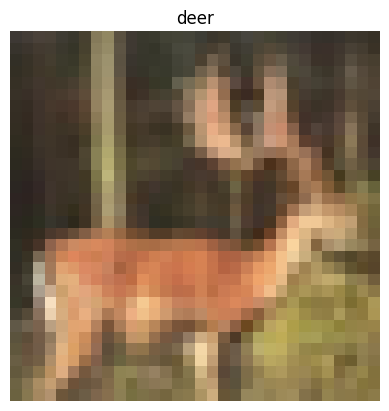

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
from cifar import load_cifar10_data, split_into_classes, get_class_indexes 
from torch.utils.data import DataLoader
import random
import os
import sys
sys.path.append(os.path.abspath("."))  # Adds the current directory
# from GEM.gem import *
from GEM.args import *
from torch.nn.functional import relu, avg_pool2d
import torch.nn as nn
import quadprog


# Globals 
DATASET_PATH = 'cifar-10-batches-py' 
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [2]:
## Scraped code fundamental for GEM this is the code required to create a resnet18 model from scratch 
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, nf):
        super(ResNet, self).__init__()
        self.in_planes = nf

        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        bsz = x.size(0)
        out = relu(self.bn1(self.conv1(x.view(bsz, 3, 32, 32))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(nclasses, nf=20):
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)




In [3]:
### Now lets make the GEM model --  we will scrape this from the GEM code
def compute_offsets(task, nc_per_task, is_cifar):
    """
        Compute offsets for cifar to determine which
        outputs to select for a given task.
    """
    offset1 = task * nc_per_task
    offset2 = (task + 1) * nc_per_task
    
    return offset1, offset2


def store_grad(pp, grads, grad_dims, tid):
    """
        This stores parameter gradients of past tasks.
        pp: parameters
        grads: gradients
        grad_dims: list with number of parameters per layers
        tid: task id
    """
    # store the gradients
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1


def overwrite_grad(pp, newgrad, grad_dims):
    """
        This is used to overwrite the gradients with a new gradient
        vector, whenever violations occur.
        pp: parameters
        newgrad: corrected gradient
        grad_dims: list storing number of parameters at each layer
    """
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1


def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    """
        Solves the GEM dual QP described in the paper given a proposed
        gradient "gradient", and a memory of task gradients "memories".
        Overwrites "gradient" with the final projected update.

        input:  gradient, p-vector
        input:  memories, (t * p)-vector
        output: x, p-vector
    """
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))


class Net(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 args):
        super(Net, self).__init__()
        nl, nh = args.n_layers, args.n_hiddens
        self.margin = args.memory_strength
        self.net = ResNet18(n_outputs)
     

        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs

        self.opt = torch.optim.SGD(self.parameters(), args.lr)

        self.n_memories = args.n_memories
        self.gpu = args.cuda


        """
        Allocate episodic memory
        n_tasks: number of tasks
        n_memories: number of memories per task
        n_inputs: number of input features
        """

        # allocate episodic memory
        self.memory_data = torch.FloatTensor(
            n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)
        if args.cuda:
            self.memory_data = self.memory_data.cuda()
            self.memory_labs = self.memory_labs.cuda()

        # allocate temporary synaptic memory
        """ This is the memory that stores the gradients of the parameters of the network
            FOR each task. This is used to check for violations of the GEM constraint
            Assume:

            The model has 3 parameters with sizes 100, 200, and 300 elements respectively.
            n_tasks = 5 (number of tasks).
            The allocated tensors would have the following shapes:

            self.grad_dims: [100, 200, 300]
            self.grads: Shape [600, 5] (600 is the sum of 100, 200, and 300).
        """
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)
        if args.cuda:
            self.grads = self.grads.cuda()

        # allocate counters
        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        self.nc_per_task = int(n_outputs / n_tasks)

    def forward(self, x, t):
        output = self.net(x)
        if t == -1:
            print("test all")
            return output
        # make sure we predict classes within the current task
        offset1 = int(t * self.nc_per_task)
        offset2 = int((t + 1) * self.nc_per_task)
        if offset1 > 0:
            output[:, :offset1].data.fill_(-10e10)
        if offset2 < self.n_outputs:
            output[:, offset2:self.n_outputs].data.fill_(-10e10)
        return output

    def observe(self, x, t, y):
        # update memory
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t

        # Update ring buffer storing examples from current task
        bsz = y.data.size(0)
        endcnt = min(self.mem_cnt + bsz, self.n_memories) #256
        effbsz = endcnt - self.mem_cnt # 256
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        # compute gradient on previous tasks
        if len(self.observed_tasks) > 1:
            for tt in range(len(self.observed_tasks) - 1):
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]

                offset1, offset2 = compute_offsets(past_task, self.nc_per_task,
                                                   self.is_cifar)
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        # now compute the grad on the current minibatch
        self.zero_grad()

        offset1, offset2 = compute_offsets(t, self.nc_per_task, self.is_cifar) 
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # check if gradient violates constraints
        if len(self.observed_tasks) > 1:
            # copy gradient
            store_grad(self.parameters, self.grads, self.grad_dims, t)
            indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                else torch.LongTensor(self.observed_tasks[:-1])
            dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                            self.grads.index_select(1, indx))
            if (dotp < 0).sum() != 0:
                project2cone2(self.grads[:, t].unsqueeze(1),
                              self.grads.index_select(1, indx), self.margin)
                # copy gradients back
                overwrite_grad(self.parameters, self.grads[:, t],
                               self.grad_dims)
        self.opt.step()


In [4]:
# define main function to run on the cifar dataset
def run_cifar(args):
    # Set up the model
    n_tasks = 2 #[2 tasks [airplane, automobile, etc], [dog , frog, etc]]
    size_of_task = 5
    n_outputs = 10
    n_inputs = 32 * 32 * 3
    model = Net(n_inputs, n_outputs, n_tasks, args)
    if args.cuda:
        model.cuda()
    model.is_cifar = True

    # Load data
    train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
    task1data, task1labels = split_into_classes(train_data, train_labels, ['airplane', 'automobile', 'bird', 'cat', 'deer'])
    task2data, task2labels = split_into_classes(train_data, train_labels, ['dog', 'frog', 'horse', 'ship', 'truck'])
    tasks = [[task1data, task1labels], [task2data,task2labels]]
    test_data_per_class_1, test_labels_per_class_1 = split_into_classes(test_data, test_labels, ['airplane', 'automobile', 'bird', 'cat', 'deer'])
    test_data_per_class_2, test_labels_per_class_2 = split_into_classes(test_data, test_labels, ['dog', 'frog', 'horse', 'ship', 'truck'])

    # Train the model
    for task in range(n_tasks):
        print("Training task: ", task  + 1)
        # train_indexes = []
        # for i in range(size_of_task):
        #     train_indexes.append(class_indexes[i + task * size_of_task])
        # random.shuffle(train_indexes)
        # train_loader = DataLoader(train_data, batch_size=args.batch_size, sampler=torch.utils.data.sampler.SubsetRandomSampler(train_indexes))
        
        x = torch.Tensor(tasks[task][0].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(tasks[task][1]).long()
    
        for epoch in range(args.n_epochs):
            for j in range(0, len(tasks[task][0]), args.batch_size):
                x = torch.Tensor(tasks[task][0].reshape(-1, 32*32*3)).float()
                y = torch.Tensor(tasks[task][1]).long()
                if args.cuda:
                    x, y = x.cuda(), y.cuda()
                x = x[j: j + args.batch_size]
                y = y[j: j + args.batch_size]
                model.train()
                model.observe(x, task, y)
            print("Epoch: ", epoch)
            
            #test the model after each epoch
            correct = 0
            total = len(tasks[task][0])
            for j in range(0,len(tasks[task][0]), args.batch_size):
                x = torch.Tensor(tasks[task][0].reshape(-1, 32*32*3)).float()
                y = torch.Tensor(tasks[task][1]).long()
                if args.cuda:
                    x, y = x.cuda(), y.cuda()
                x = x[j: j + args.batch_size]
                y = y[j: j + args.batch_size]
                output = model.forward(x, task)
                pred = output.data.max(1)[1]
                correct += (pred == y).sum().item()
            print("Accuracy: ", correct / total)
            #   output loss only

        correct = 0
        total = len(test_data_per_class_1)     

        # Test the model
        print("Testing task: 1")
        for j in range(0,len(test_data_per_class_1), args.batch_size):
            x = torch.Tensor(test_data_per_class_1.reshape(-1, 32*32*3)).float()
            y = torch.Tensor(test_labels_per_class_1).long()
            if args.cuda:
                x, y = x.cuda(), y.cuda()
            x = x[j: j + args.batch_size]
            y = y[j: j + args.batch_size]
            output = model.forward(x, 0)
            pred = output.data.max(1)[1]
            correct += (pred == y).sum().item()
        print("Accuracy: ", correct / total)
        
        # test task 2
        correct = 0
        total = len(test_data_per_class_2)
        
        print("Testing task: 2")
        for j in range(0,len(test_data_per_class_2), args.batch_size):
            x = torch.Tensor(test_data_per_class_2.reshape(-1, 32*32*3)).float()
            y = torch.Tensor(test_labels_per_class_2).long()
            if args.cuda:
                x, y = x.cuda(), y.cuda()
            x = x[j: j + args.batch_size]
            y = y[j: j + args.batch_size]
            output = model.forward(x, 1)
            pred = output.data.max(1)[1]
            correct += (pred == y).sum().item()
        print("Accuracy: ", correct / total)
        
    return model

        
model = run_cifar(Args())

Training task:  1
Epoch:  0
Accuracy:  0.65924
Epoch:  1
Accuracy:  0.75852
Epoch:  2
Accuracy:  0.81072
Testing task: 1
Accuracy:  0.7538
Testing task: 2
Accuracy:  0.2276
Training task:  2
Epoch:  0
Accuracy:  0.88464
Epoch:  1
Accuracy:  0.92448
Epoch:  2
Accuracy:  0.94292
Testing task: 1
Accuracy:  0.6562
Testing task: 2
Accuracy:  0.8838


In [ ]:
# Load data
train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
args = Args()
# test the model on task 1 and task 2
correct = 0

total = len(test_data)

for j in range(0,len(test_data), args.batch_size):
    x = torch.Tensor(test_data.reshape(-1, 32*32*3)).float()
    y = torch.Tensor(test_labels).long()
    if args.cuda:
        x, y = x.cuda(), y.cuda()
    x = x[j: j + args.batch_size]
    y = y[j: j + args.batch_size]
    output = model.forward(x, -1)
    pred = output.data.max(1)[1]
    correct += (pred == y).sum().item()
print("Accuracy: ", correct / total)

test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
test all
t